# 操作1

In [2]:
%%HTML
<style>
    body {
        --vscode-font-family: 霞鹜文楷, Consolas, 'Courier New', monospace
    }
</style>

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

# 数据准备

In [5]:
from model.timegrad.util import get_mydata

path = "./data/diabetes1.csv"
data_name = "electricity_nips"
freq = "S"
train_data, test_data, features_num = get_mydata(
    isGluontsData=False, data_path=path, data_name=data_name, freq=freq
)

In [6]:
from diffusers import DEISMultistepScheduler
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

# 训练开始

In [7]:
# 加载参数
import yaml

# 加载 YAML 配置文件
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
estimator_config = config["estimator"]

In [8]:
from model.timegrad.estimator import TimeGradEstimator

estimator = TimeGradEstimator(
    lr=0.001,
    input_size=features_num,  # 多元数据的特征数量
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=estimator_config["prediction_length"],
    context_length=estimator_config["context_length"],
    freq=freq,
    scaling="mean",
    batch_size=64,
    num_batches_per_epoch=2,
    trainer_kwargs=dict(max_epochs=2, accelerator="gpu", devices="1"),
)
predictor = estimator.train(train_data, num_workers=8)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


rnn_input_size:23



  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 73.4 K | train | [[1, 1], [1, 1], [1, 36, 7], [1, 36, 7], [1, 36, 7], [1, 12, 7]] | [1, 100, 12, 7]
-------------------------------------------------------------------------------------------------------------------------------------
73.4 K    Trainable params
0         Non-trainable params
73.4 K    Total params
0.293     Total estimated model params size (MB)


Epoch 0: |          | 2/? [00:00<00:00,  2.87it/s, v_num=6, train_loss=0.428]

Epoch 0, global step 2: 'train_loss' reached 0.42848 (best 0.42848), saving model to '/home/songzy/myDL/CSI-prediction/lightning_logs/version_6/checkpoints/epoch=0-step=2.ckpt' as top 1


Epoch 1: |          | 2/? [00:00<00:00,  7.59it/s, v_num=6, train_loss=0.419]

Epoch 1, global step 4: 'train_loss' reached 0.41853 (best 0.41853), saving model to '/home/songzy/myDL/CSI-prediction/lightning_logs/version_6/checkpoints/epoch=1-step=4.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: |          | 2/? [00:00<00:00,  6.32it/s, v_num=6, train_loss=0.419]
rnn_input_size:23


# 根据测试集和训练的预测器进行采样

In [9]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, targets_it = make_evaluation_predictions(
    dataset=test_data, predictor=predictor, num_samples=config['forecast']['num_samples']
)

In [10]:
forecasts = list(forecast_it)
targets = list(targets_it)

# 画出预测图

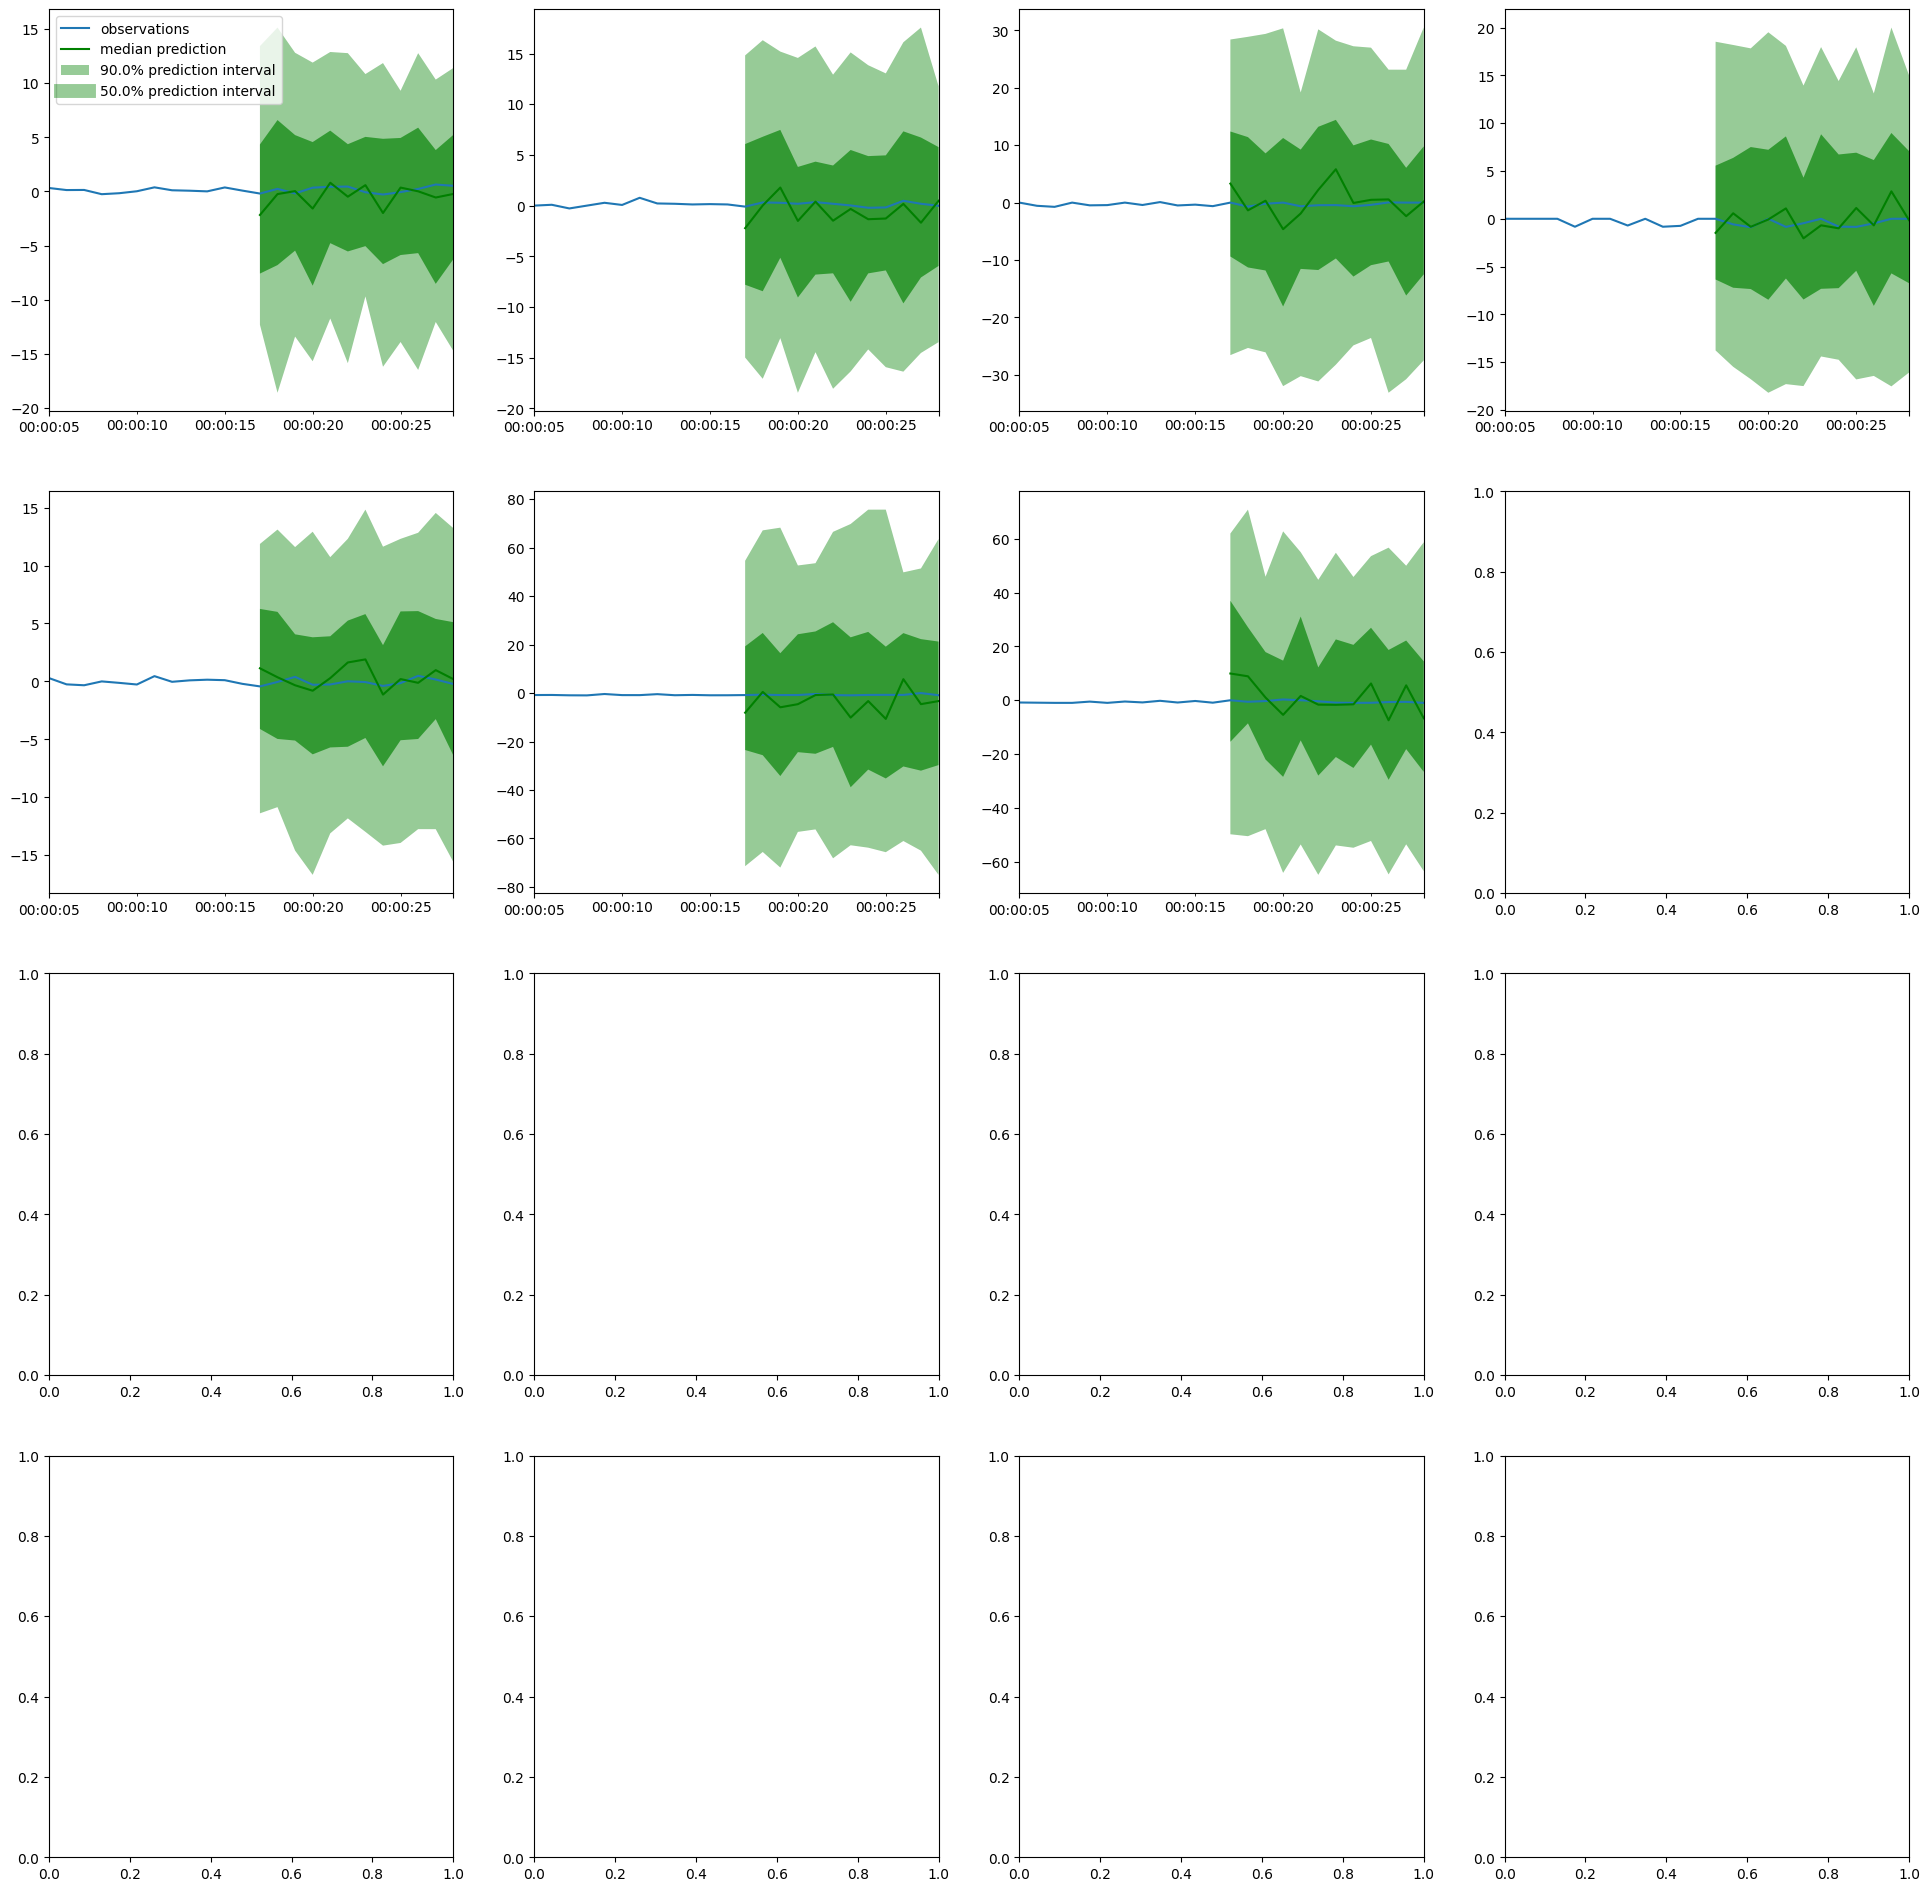

In [11]:
from model.timegrad.util import forecast_plot

forecast_plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=estimator_config['prediction_length'],
)
plt.show()

# 评估

In [12]:
from gluonts.evaluation import MultivariateEvaluator

evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)
agg_metric, item_metrics = evaluator(
    targets, forecasts, num_series=len(test_data)
)

Running evaluation: 1it [00:00, 66.86it/s]
Running evaluation: 1it [00:00, 96.71it/s]
Running evaluation: 1it [00:00, 114.86it/s]
Running evaluation: 1it [00:00, 117.28it/s]
Running evaluation: 1it [00:00, 100.76it/s]
Running evaluation: 1it [00:00, 119.58it/s]
Running evaluation: 1it [00:00, 121.42it/s]
Running evaluation: 1it [00:00, 106.58it/s]


In [15]:
from model.timegrad.util import create_metric_table
from tabulate import tabulate
metric= create_metric_table(agg_metric)
# 使用tabulate库美观地展示表格
table_str = tabulate(metric, headers='keys', tablefmt='psql', showindex=False)
print(table_str)

+---------+---------+---------+---------+------------+----------+-------------+------------+
|    CRPS |      ND |     MSE |   NRMSE |   CRPS-Sum |   ND-Sum |   NRMSE-Sum |   NMSE-Sum |
|---------+---------+---------+---------+------------+----------+-------------+------------|
| 11.4692 | 5.48262 | 7.42089 | 6.99838 |    8.23233 |  4.17673 |     4.63447 |    21.4783 |
+---------+---------+---------+---------+------------+----------+-------------+------------+
